# The Model

The model to train a CNN model on the MNSIT dataset 

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    batch_size=64
    test_batch_size=1000
    epochs=3
    lr=1
    gamma=0.7
    no_cuda=False
    seed=1
    log_interval=10
    save_model=False
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../mnsit_data', train=True, download=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../mnsit_data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    for epoch in range(1, epochs + 1):
        train(log_interval, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
        
    return model,train_loader


am,bm=main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333409
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.268057
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.859085
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.609946
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.394730
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.440521
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.293486
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.187813
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.438220
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.294567
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.355207
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.301192
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.384063
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.246006
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.320096
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.075280
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.087685
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.199955
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.353506
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.100272
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.041183
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.078097
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.015895
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.146496
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.037851
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.042704
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.009089
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.024364
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.041623
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.048635
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.012120
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.154356
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.070946
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.026465
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.052212
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.007162
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.003801
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.007629
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.019802
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.022955


# Optimal Transport

Calculating the optimal transport distances at different layers


Calculating the first and the second convolutional layers for a data

In [8]:
use_cuda =torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
for data,label in bm:
    am.eval()
    data,label=data.to(device), label.to(device)
    x1=am.conv1(data)
    x1=F.relu(x1) # The first covolutional layer 
    x2 = am.conv2(x1)
    x2 = F.relu(x2) #The second convolutional layer
    break
x1=x1.to('cpu').detach().numpy()
x2=x2.to('cpu').detach().numpy()

Generating the cost matrices

In [5]:
import math
import numpy as np
co1=np.zeros((676,676))
for i in range(676):
    for j in range(i,676):
        a=math.floor(i/26)
        b=i%26
        if i==j:
            co1[i][j]=0
        else:
            a1=math.floor(j/26)
            b1=j%26
            q=100*math.sqrt((a-a1)*(a-a1)+(b-b1)*(b-b1))
            co1[i][j]=q
            co1[j][i]=q
            
co2=np.zeros((576,576))
for i in range(576):
    for j in range(i,576):
        a=math.floor(i/24)
        b=i%24
        if i==j:
            co1[i][i]=0
        else:
            a1=math.floor(j/24)
            b1=j%24
            q=100*math.sqrt((a-a1)*(a-a1)+(b-b1)*(b-b1))
            co2[i][j]=q
            co2[j][i]=q

Calculating the exact distances for the batch of data

In [10]:
import ot
va1=np.zeros((32,64,64))
for i in range(64):
    for j in range(i,64):
        if i==j:
            va1[:,i,j]=0
        else:
            e=x1[i].reshape((32,26,26)).astype('float64')
            f=x1[j].reshape((32,26,26)).astype('float64')
            
            for k in range(32):
                dis=ot.emd2(e[k].reshape((676))/(np.sum(e[k].reshape((676)),axis=0)),f[k].reshape((676))/(np.sum(f[k].reshape((676)),axis=0)),co1)
                va1[k][i][j]=dis
                va1[k][j][i]=dis
va2=np.zeros((64,64,64))
for i in range(64):
    for j in range(i,64):
        if i==j:
            va2[:,i,j]=0
        else:
            e=x2[i].reshape((64,24,24)).astype('float64')
            f=x2[j].reshape((64,24,24)).astype('float64')
            
            for k in range(64):
                dis=ot.emd2(e[k].reshape((576))/(np.sum(e[k].reshape((576)),axis=0)),f[k].reshape((576))/(np.sum(f[k].reshape((576)),axis=0)),co2)
                va2[k][i][j]=dis
                va2[k][j][i]=dis
va1=np.sum(va1,axis=0)/32 #averaging it between the number of channels
va2=np.sum(va2,axis=0)/64

C:\Users\Ayush Shrivastav\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Storing the distance value in the 55 possible categories

In [11]:
a=np.zeros((10,10))
b=np.zeros((10,10))
for i in range(64):
    for j in range(i,64):
        a[int(label[j])][int(label[i])]+=va1[int(label[j])][int(label[i])]
        b[int(label[j])][int(label[i])]+=1
        if label[i]!=label[j]:
            a[int(label[i])][int(label[j])]+=va1[int(label[i])][int(label[j])]
            b[int(label[i])][int(label[j])]+=1
z1=a/b # the average of these distances
a=np.zeros((10,10))
b=np.zeros((10,10))
for i in range(64):
    for j in range(i,64):
        a[int(label[j])][int(label[i])]+=va2[int(label[j])][int(label[i])]
        b[int(label[j])][int(label[i])]+=1
        if label[i]!=label[j]:
            a[int(label[i])][int(label[j])]+=va2[int(label[i])][int(label[j])]
            b[int(label[i])][int(label[j])]+=1
z2=a/b

Data distribution

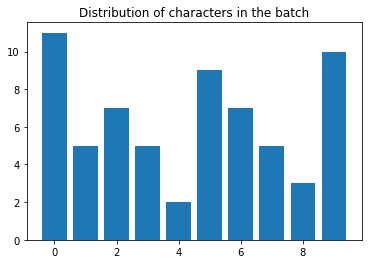

In [13]:
import matplotlib.pyplot as plt
x=[0,1,2,3,4,5,6,7,8,9]
y=np.zeros((10))
for i in range(64):
    y[int(label[i])]+=1
plt.bar(x,y)
plt.title('Distribution of characters in the batch')
plt.show()

The graphs of the optimal disatnces for each character

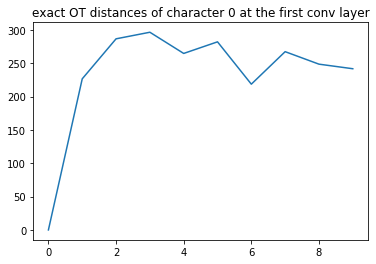

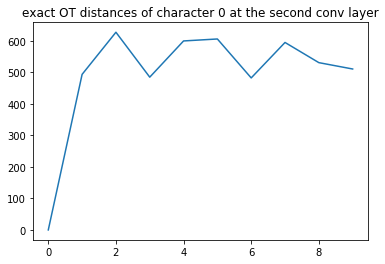

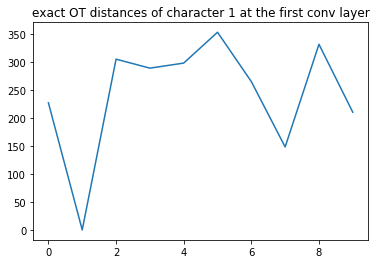

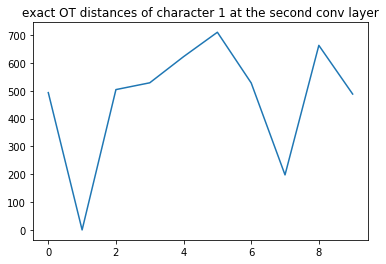

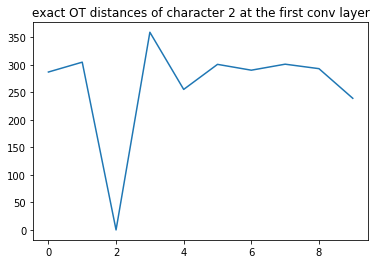

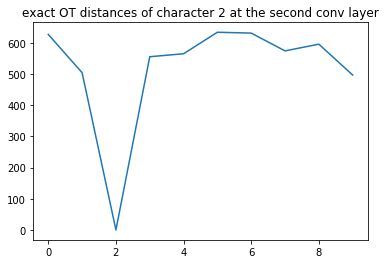

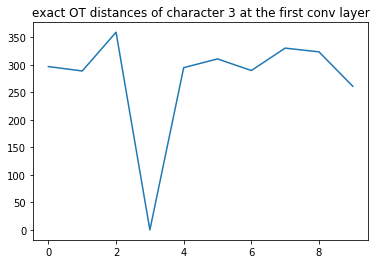

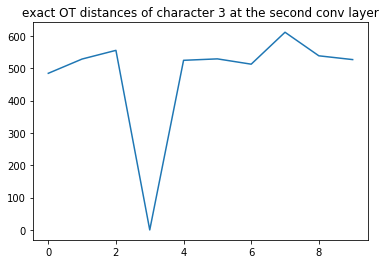

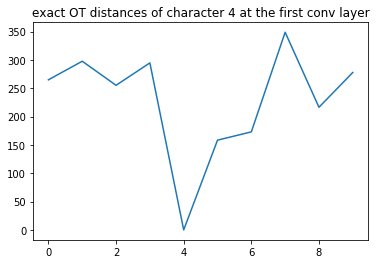

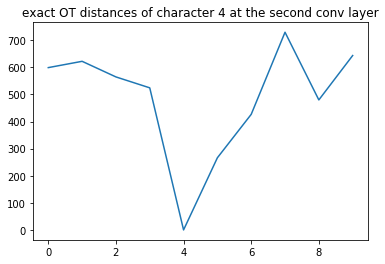

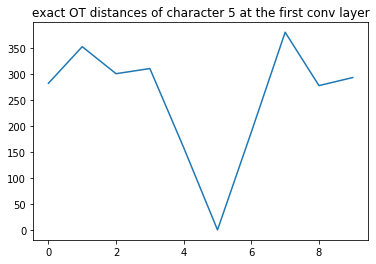

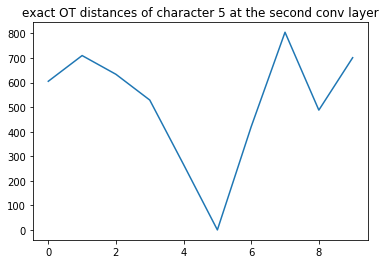

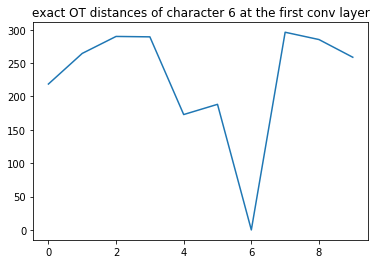

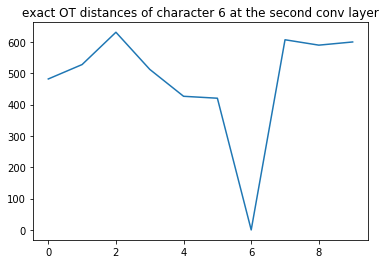

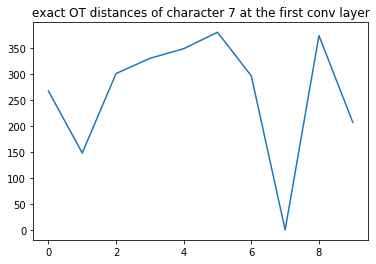

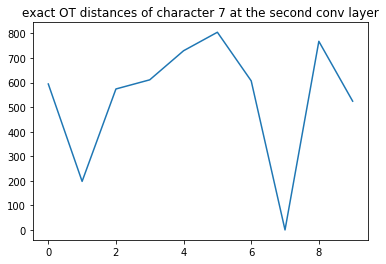

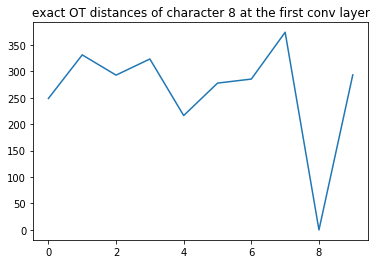

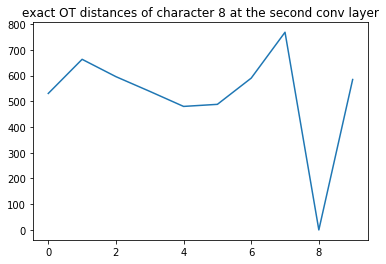

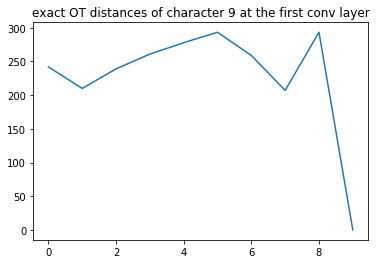

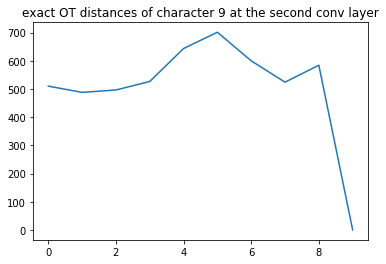

In [14]:
for i in range(10):
    plt.plot(x,z1[i])
    plt.title('exact OT distances of character '+str(i)+' at the first conv layer')
    plt.show()
    plt.plot(x,z2[i])
    plt.title('exact OT distances of character '+str(i)+' at the second conv layer')
    plt.show()